In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

In [3]:
df_join = pd.read_excel('../data/data_joined_16-23_no_new_buildings.xlsx')

In [4]:
df_infl = pd.read_excel('../data/constructed/inflation-rate-in-kazakhstan-2028.xlsx', sheet_name='Data')
df_infl['Year'] = pd.to_numeric(df_infl['Year'].str.replace('*',''))
df_infl=df_infl[pd.to_numeric(df_infl.Year)>=2016]

C:\Users\User\AppData\Local\Temp\ipykernel_5032\1026236143.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_infl['Year'] = pd.to_numeric(df_infl['Year'].str.replace('*',''))


Text(0, 0.5, 'price in tg')

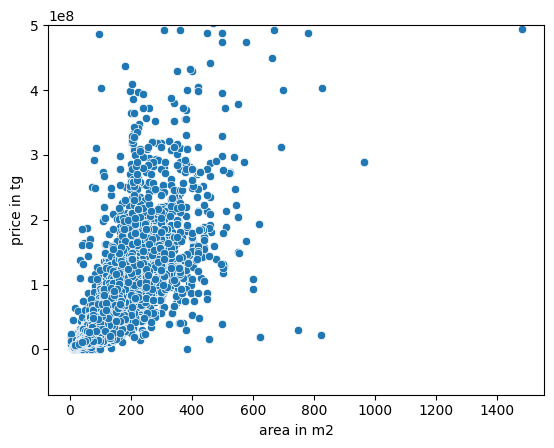

In [10]:
sns.scatterplot(x=df_join['area'],y=df_join['price_adj'])
# plt.xlim(right  =200)
plt.ylim(top=0.5*1e9)

plt.xlabel('area in m2')
plt.ylabel('price in tg')

In [14]:
import statsmodels.formula.api as smf

#fit regression model
fit = smf.ols('price_adj ~ area', data=df_join).fit()

#view model summary
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:              price_adj   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                 2.230e+05
Date:                Tue, 23 May 2023   Prob (F-statistic):               0.00
Time:                        12:15:16   Log-Likelihood:            -2.3415e+06
No. Observations:              129713   AIC:                         4.683e+06
Df Residuals:                  129711   BIC:                         4.683e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -9.298e+06   8.91e+04   -104.346      0.0

In [16]:
from statsmodels.compat import lzip
import statsmodels.stats.api as sms

#perform Bresuch-Pagan test
names = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(fit.resid, fit.model.exog)

lzip(names, test)


[('Lagrange multiplier statistic', 5474.42153628914),
 ('p-value', 0.0),
 ('f-value', 5715.557121421944),
 ('f p-value', 0.0)]

Heteroscedasticity is present

In [24]:
from scipy import spatial
trees = [
    spatial.KDTree(df_join[df_join['YEAR']==year][['Latitude','Longitude']].to_numpy()) for year in df_join.YEAR.unique() 
]
key_tree = dict(zip(range(2016,2023+1),trees))
# tree16 = spatial.KDTree(df_join[df_join['YEAR']==2016][['Latitude','Longitude']].to_numpy())
# tree17 = spatial.KDTree(df_join[df_join['YEAR']==2017][['Latitude','Longitude']].to_numpy())
# tree18 = spatial.KDTree(df_join[df_join['YEAR']==2018][['Latitude','Longitude']].to_numpy())
# tree19 = spatial.KDTree(df_join[df_join['YEAR']==2019][['Latitude','Longitude']].to_numpy())
# tree20 = spatial.KDTree(df_join[df_join['YEAR']==2020][['Latitude','Longitude']].to_numpy())
# tree21 = spatial.KDTree(df_join[df_join['YEAR']==2021][['Latitude','Longitude']].to_numpy())
# tree22 = spatial.KDTree(df_join[df_join['YEAR']==2022][['Latitude','Longitude']].to_numpy())
# tree23 = spatial.KDTree(df_join[df_join['YEAR']==2023][['Latitude','Longitude']].to_numpy())
# key_tree = dict(zip(range(2016,2023+1), [tree16,tree17,tree18,tree19,tree20,tree21,tree22,tree23]))
def get_neigbours(row, n_neighbors = 5):
    tree = key_tree[row['YEAR']]
    df_send = df_join[df_join['YEAR'] == row['YEAR']]    
    distances, indexes = tree.query([row['Latitude'], row['Longitude']], k=n_neighbors+1)
 
    indexes = [index for distance, index in zip(distances, indexes)]

    return df_send.iloc[indexes[0]]

def is_best_view(row, n_neighbors=5):
    neibgours = get_neigbours(row, n_neighbors)
    # try:
    return int(neibgours['total_floor'].max())<= int(row['floor'])
    # except:
        # return False

In [25]:
df_join['best_view'] = df_join.apply(lambda row: is_best_view(row, 2), axis=1)

In [27]:
df_join['best_view'].value_counts()

False    99219
True     30494
Name: best_view, dtype: int64

In [36]:
def get_weighted_dist_centers(long: float, lat: float):
    akimat = (10000 *43.258498, 10000 * 76.941818)
    stadion = (10000 * 43.238332, 10000 * 76.923358)
    center_sqare = (10000 * 43.238551, 10000 * 76.945410)
    long *= 10000
    lat *= 10000
    akimat_dist = ((long - akimat[1]) ** 2 + (lat - akimat[0]) ** 2) ** 0.5
    stadion_dist = ((long - stadion[1]) ** 2 + (lat - stadion[0]) ** 2) ** 0.5
    center_sqare_dist = ((long - center_sqare[1]) ** 2 + (lat - center_sqare[0]) ** 2) ** 0.5
    return (0.3*akimat_dist + 0.4*stadion_dist + 0.3*center_sqare_dist) 

def get_weighted_dist_mall(long: float, lat:float):
    dostyk =  (10000 *43.233486, 10000 *76.956623)
    esentai = (10000 *43.218748, 10000 *76.928182)
    mega_rosa = (10000 *43.202449, 10000 *76.891970)
    mega3 = (10000 *43.264112, 10000 *76.929592)
    
    long *= 10000
    lat *= 10000
    dostyk_dist = (abs(long - dostyk[1])  + abs(lat - dostyk[0]))
    esentai_dist = (abs(long - esentai[1])  + abs(lat - esentai[0]))
    mega_rosa_dist = (abs(long - mega_rosa[1]) + abs(lat - mega_rosa[0]))
    mega3_dist = (abs(long - mega3[1]) + abs(lat - mega3[0]))
    
    return min([mega_rosa_dist,esentai_dist,mega3_dist,dostyk_dist])



In [38]:
df_join['weighted_dist_centers'] = df_join[['Longitude', 'Latitude']].apply(lambda row: get_weighted_dist_centers(float(row[0]), float(row[1])), axis=1)

In [56]:
df_join['weighted_dist_malls'] = df_join[['Longitude', 'Latitude']].apply(lambda row: get_weighted_dist_mall(float(row[0]), float(row[1])), axis=1)

In [70]:
kg = pd.read_excel('../data/constructed/Kindergardens Coordianes.xlsx')
kg = kg.drop(columns=['Name']).dropna()
kg = kg.rename(columns={'Coordinates ':'Coordinates_tuples'})

def get_weighted_dist_kindergarden(long: float, lat:float):
    return min(kg['Coordinates_tuples'].apply(lambda x: abs(float(x[0]) - lat) + abs(float(x[1]) - long)))

In [71]:
df_join['weighted_dist_kindergarden'] = df_join[['Longitude', 'Latitude']].apply(lambda row: get_weighted_dist_kindergarden(float(row[0]), float(row[1])), axis=1)

<AxesSubplot: xlabel='weighted_dist_centers', ylabel='Count'>

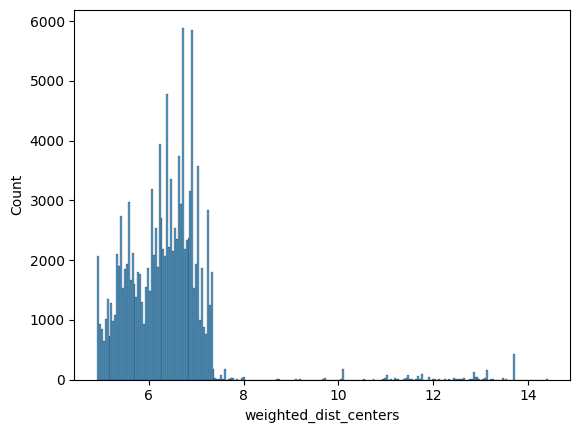

In [48]:
sns.histplot(np.log(df_join['weighted_dist_centers']))


In [87]:
def mid_floor_dist(row):
    return  abs((row['floor']-(1+row['total_floor'])/2))

In [92]:
df_join['floor_mid_dist'] = df_join.apply(lambda x: mid_floor_dist(x), axis=1)

(-0.28236060615839037, 15.0)

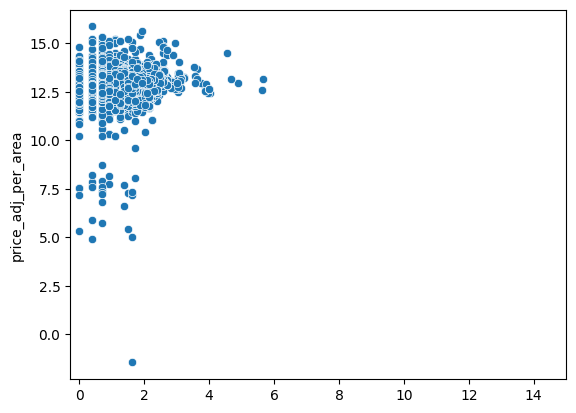

In [91]:
sns.scatterplot(x=np.log(df_join.apply(lambda x: mid_floor_dist(x), axis=1)+1), y=np.log(df_join['price_adj_per_area']))

plt.xlim(right=15)

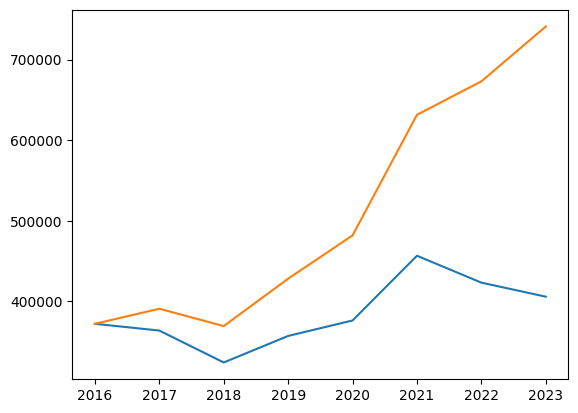

In [194]:
sample_means = df_join.groupby('YEAR', as_index=False).apply(lambda x: x.sample(20)).groupby('YEAR')[['price_adj_per_area','price_per_area']].mean()
plt.plot(sample_means)

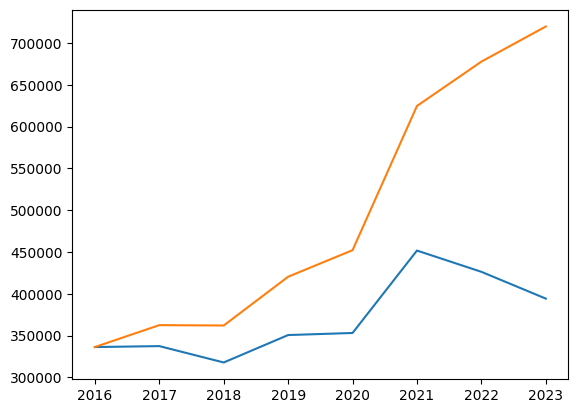

In [196]:
sample_means = df_join.groupby('YEAR')[['price_adj_per_area','price_per_area']].mean()
plt.plot(sample_means)

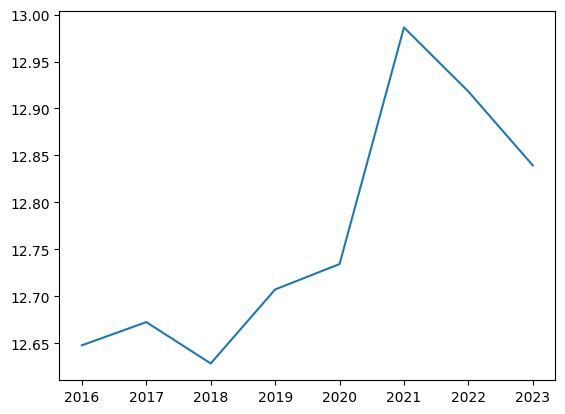

In [214]:
sample_means = df_join.groupby('YEAR')[['log_price_adj_per_area']].mean()
plt.plot(sample_means)

In [209]:
LinearRegression().fit(df_join[['YEAR']],df_join['price_per_area']).coef_

array([63018.22819807])

<AxesSubplot: ylabel='Count'>

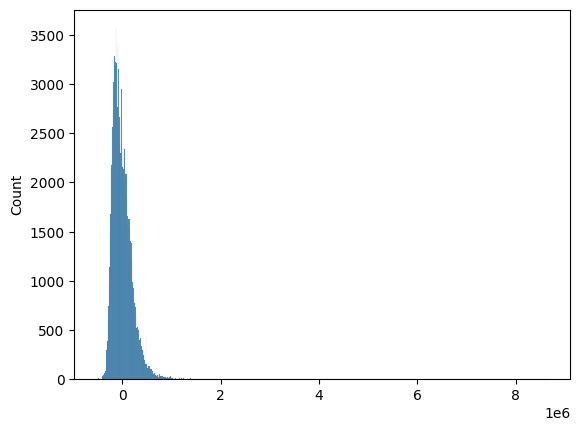

In [206]:
sns.histplot(df_join['price_per_area'] - df_join['YEAR'] * 63018.22819807)

In [79]:
df_join.loc[df_join['total_floor'] == 0,'total_floor'] = -1

In [84]:
df_join[df_join.floor > df_join.total_floor].YEAR.value_counts()

2021    156
2023    122
2019     26
2020     16
2017      4
Name: YEAR, dtype: int64

In [93]:
df_join.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'area', 'price', 'floor', 'year_built',
       'region', 'total_floor', 'Latitude', 'Longitude', 'YEAR', 'Regions',
       'Multiplier', 'Regions_Alatau', 'Regions_Almaly', 'Regions_Almaty',
       'Regions_Auezov', 'Regions_Bostandyq', 'Regions_Jetysu',
       'Regions_Medeu', 'Regions_Nauryzbai', 'Regions_Turksib', 'price_adj',
       'price_adj_per_area', 'price_per_area', 'building_age',
       'log_price_adj_per_area', 'best_view', 'weighted_dist_centers',
       'weighted_dist_malls', 'weighted_dist_kindergarden', 'floor_mid_dist'],
      dtype='object')

In [94]:
from sklearn.linear_model import LinearRegression

In [109]:
df_join['floor_interaction'] = df_join['floor']*df_join['total_floor']

In [174]:
x = df_join[['building_age', 'area',
       'best_view', 'weighted_dist_centers',
       'weighted_dist_malls', 'weighted_dist_kindergarden', 'floor_mid_dist', 'YEAR','total_floor', 'Latitude', 'Longitude','Regions_Alatau', 'Regions_Almaly', 'Regions_Almaty',
       'Regions_Auezov', 'Regions_Bostandyq', 'Regions_Jetysu',
       'Regions_Medeu', 'Regions_Nauryzbai', 'Regions_Turksib']]
y = np.log(df_join['price_per_area'])

In [175]:
LinearRegression().fit(x,y).score(x,y)

0.5582079338154284

In [217]:
LinearRegression().fit(x,y).coef_[7]*2023

90.82255623496185

In [186]:
x = df_join[['building_age', 'area',
       'best_view', 'weighted_dist_centers',
       'weighted_dist_malls', 'weighted_dist_kindergarden', 'floor_mid_dist', 'YEAR','total_floor', 'Latitude', 'Longitude','Regions_Alatau', 'Regions_Almaly', 'Regions_Almaty',
       'Regions_Auezov', 'Regions_Bostandyq', 'Regions_Jetysu',
       'Regions_Medeu', 'Regions_Nauryzbai', 'Regions_Turksib']]
y = np.log(df_join['price_adj_per_area'])

LinearRegression().fit(x,y).score(x,y)

0.34528564569475706

In [176]:
from sklearn.model_selection import KFold

In [182]:
scores=[]
kf = KFold(n_splits=10, shuffle=True)        
x, y = df_join[['building_age', 'area',
       'best_view', 'weighted_dist_centers',
       'weighted_dist_malls', 'weighted_dist_kindergarden', 'floor_mid_dist', 'YEAR','total_floor', 'Latitude', 'Longitude','Regions_Alatau', 'Regions_Almaly', 'Regions_Almaty',
       'Regions_Auezov', 'Regions_Bostandyq', 'Regions_Jetysu',
       'Regions_Medeu', 'Regions_Nauryzbai', 'Regions_Turksib']], df_join['price_per_area']
kf.get_n_splits(x, y)
for train_index,test_index in kf.split(x, y):    
    X_train, X_test, y_train, y_test = x.iloc[train_index], x.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
    scores.append(LinearRegression().fit(X_train, y_train).score(X_test, y_test))

In [183]:
scores

[0.5021466915384982,
 0.4525974952159382,
 0.45049069500291083,
 0.43516963559161637,
 0.44895477764150993,
 0.5332243932518045,
 0.4825938752818604,
 0.4155103275412968,
 0.4545811073980507,
 0.4358205598628677]

In [126]:
from sklearn.linear_model import Lasso

In [129]:
Lasso(alpha=0.01).fit(x,y).score(x,y)

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.363e+03, tolerance: 1.931e+00
  model = cd_fast.enet_coordinate_descent(


0.5047948531139584

In [142]:
x_train = df_join[(df_join['YEAR']<2022) & (df_join['YEAR']>2015)][['building_age',
       'best_view', 'weighted_dist_centers',
       'weighted_dist_malls', 'weighted_dist_kindergarden', 'floor_mid_dist', 'YEAR', 'floor','total_floor', 'Latitude', 'Longitude','Regions_Alatau', 'Regions_Almaly', 'Regions_Almaty',
       'Regions_Auezov', 'Regions_Bostandyq', 'Regions_Jetysu',
       'Regions_Medeu', 'Regions_Nauryzbai', 'Regions_Turksib']]
y_train = np.log(df_join[(df_join['YEAR']<2022) & (df_join['YEAR']>2015)]['price_per_area'])

x_test = df_join[df_join['YEAR']==2022][['building_age',
        'best_view', 'weighted_dist_centers',
       'weighted_dist_malls', 'weighted_dist_kindergarden', 'floor_mid_dist', 'YEAR', 'floor','total_floor', 'Latitude', 'Longitude','Regions_Alatau', 'Regions_Almaly', 'Regions_Almaty',
       'Regions_Auezov', 'Regions_Bostandyq', 'Regions_Jetysu',
       'Regions_Medeu', 'Regions_Nauryzbai', 'Regions_Turksib']]
y_test = np.log(df_join[df_join['YEAR']==2022]['price_per_area'])

In [143]:
LinearRegression().fit(x_train, y_train).score(x_test,y_test)

0.22554452599505026

<AxesSubplot: >

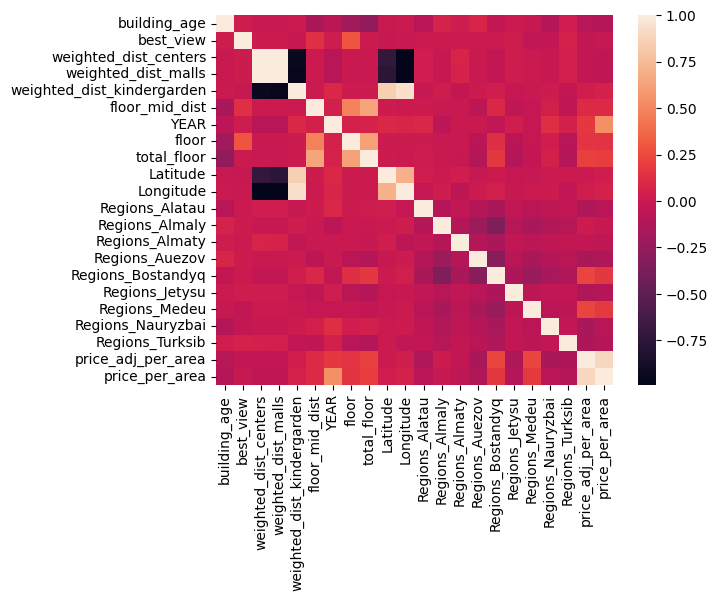

In [153]:
sns.heatmap(df_join[['building_age',
       'best_view', 'weighted_dist_centers',
       'weighted_dist_malls', 'weighted_dist_kindergarden', 'floor_mid_dist', 'YEAR', 'floor','total_floor', 'Latitude', 'Longitude','Regions_Alatau', 'Regions_Almaly', 'Regions_Almaty',
       'Regions_Auezov', 'Regions_Bostandyq', 'Regions_Jetysu',
       'Regions_Medeu', 'Regions_Nauryzbai', 'Regions_Turksib','price_adj_per_area','price_per_area']].corr())

In [155]:
#time series cross valid
scores = []
for year in range(2018, 2024):
       x_train = df_join[(df_join['YEAR']<year) & (df_join['YEAR']>2015)][['building_age',
       'best_view', 'weighted_dist_centers',
       'weighted_dist_malls', 'weighted_dist_kindergarden', 'floor_mid_dist', 'YEAR', 'floor','total_floor', 'Latitude', 'Longitude','Regions_Alatau', 'Regions_Almaly', 'Regions_Almaty',
       'Regions_Auezov', 'Regions_Bostandyq', 'Regions_Jetysu',
       'Regions_Medeu', 'Regions_Nauryzbai', 'Regions_Turksib']]
       y_train = np.log(df_join[(df_join['YEAR']<year) & (df_join['YEAR']>2015)]['price_per_area'])

       x_test = df_join[df_join['YEAR']==year][['building_age',
              'best_view', 'weighted_dist_centers',
              'weighted_dist_malls', 'weighted_dist_kindergarden', 'floor_mid_dist', 'YEAR', 'floor','total_floor', 'Latitude', 'Longitude','Regions_Alatau', 'Regions_Almaly', 'Regions_Almaty',
              'Regions_Auezov', 'Regions_Bostandyq', 'Regions_Jetysu',
              'Regions_Medeu', 'Regions_Nauryzbai', 'Regions_Turksib']]
       y_test = np.log(df_join[df_join['YEAR']==year]['price_per_area'])

       scores.append(LinearRegression().fit(x_train, y_train).score(x_test,y_test))

In [156]:
scores

[0.3897874175072146,
 0.3559881778583569,
 0.3671705859030171,
 -1.070456639878481,
 0.22554452599505026,
 0.2934450715429109]

In [158]:
for test_year, score in zip(range(2018,2024),scores):
    train_years = map(str,range(2016,test_year))
    print('Training on', ' '.join(train_years),'| Testing on', test_year, '| R^2', score) 

Training on 2016 2017 | Testing on 2018 | R^2 0.3897874175072146
Training on 2016 2017 2018 | Testing on 2019 | R^2 0.3559881778583569
Training on 2016 2017 2018 2019 | Testing on 2020 | R^2 0.3671705859030171
Training on 2016 2017 2018 2019 2020 | Testing on 2021 | R^2 -1.070456639878481
Training on 2016 2017 2018 2019 2020 2021 | Testing on 2022 | R^2 0.22554452599505026
Training on 2016 2017 2018 2019 2020 2021 2022 | Testing on 2023 | R^2 0.2934450715429109


In [150]:
#time series cross valid
scores = []
for year in range(2017, 2024):
       x_train = df_join[(df_join['YEAR']<year) & (df_join['YEAR']>year-4)][['building_age',
       'best_view', 'weighted_dist_centers',
       'weighted_dist_malls', 'weighted_dist_kindergarden', 'floor_mid_dist', 'YEAR', 'floor','total_floor', 'Latitude', 'Longitude','Regions_Alatau', 'Regions_Almaly', 'Regions_Almaty',
       'Regions_Auezov', 'Regions_Bostandyq', 'Regions_Jetysu',
       'Regions_Medeu', 'Regions_Nauryzbai', 'Regions_Turksib']]
       y_train = np.log(df_join[(df_join['YEAR']<year) & (df_join['YEAR']>year-4)]['price_per_area'])

       x_test = df_join[df_join['YEAR']==year][['building_age',
              'best_view', 'weighted_dist_centers',
              'weighted_dist_malls', 'weighted_dist_kindergarden', 'floor_mid_dist', 'YEAR', 'floor','total_floor', 'Latitude', 'Longitude','Regions_Alatau', 'Regions_Almaly', 'Regions_Almaty',
              'Regions_Auezov', 'Regions_Bostandyq', 'Regions_Jetysu',
              'Regions_Medeu', 'Regions_Nauryzbai', 'Regions_Turksib']]
       y_test = np.log(df_join[df_join['YEAR']==year]['price_per_area'])

       scores.append(LinearRegression().fit(x_train, y_train).score(x_test,y_test))

In [171]:
df_join['floor_percent'] = df_join['floor']/df_join['total_floor']

In [167]:
#time series cross valid
scores = []
for year in range(2023, 2024):
        x_train = df_join[(df_join['YEAR']<year) & (df_join['YEAR']>2015)][['building_age',
        'best_view', 'weighted_dist_centers',
        'weighted_dist_malls', 'weighted_dist_kindergarden', 'floor_mid_dist', 'YEAR', 'floor','total_floor', 'Latitude', 'Longitude','Regions_Alatau', 'Regions_Almaly', 'Regions_Almaty',
        'Regions_Auezov', 'Regions_Bostandyq', 'Regions_Jetysu',
        'Regions_Medeu', 'Regions_Nauryzbai', 'Regions_Turksib']]
        y_train = np.log(df_join[(df_join['YEAR']<year) & (df_join['YEAR']>2015)]['price_per_area'])

        x_test = df_join[df_join['YEAR']==year][['building_age',
              'best_view', 'weighted_dist_centers',
              'weighted_dist_malls', 'weighted_dist_kindergarden', 'floor_mid_dist', 'YEAR', 'floor','total_floor', 'Latitude', 'Longitude','Regions_Alatau', 'Regions_Almaly', 'Regions_Almaty',
              'Regions_Auezov', 'Regions_Bostandyq', 'Regions_Jetysu',
              'Regions_Medeu', 'Regions_Nauryzbai', 'Regions_Turksib']]
        y_test = np.log(df_join[df_join['YEAR']==year]['price_per_area'])

        coef_value = Lasso(alpha=0.001).fit(x_train, y_train).coef_ 
        coef = zip(['building_age',
              'best_view', 'weighted_dist_centers',
              'weighted_dist_malls', 'weighted_dist_kindergarden', 'floor_mid_dist', 'YEAR', 'floor','total_floor', 'Latitude', 'Longitude','Regions_Alatau', 'Regions_Almaly', 'Regions_Almaty',
              'Regions_Auezov', 'Regions_Bostandyq', 'Regions_Jetysu',
              'Regions_Medeu', 'Regions_Nauryzbai', 'Regions_Turksib'],coef_value)
        scores.append(Lasso(alpha=0.001).fit(x_train, y_train).score(x_test,y_test))

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.667e+03, tolerance: 1.265e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.667e+03, tolerance: 1.265e+00
  model = cd_fast.enet_coordinate_descent(


In [168]:
scores

[0.2992855101393713]

In [169]:
print([variable for variable, coef_val in coef if coef_val>0])

['weighted_dist_malls', 'weighted_dist_kindergarden', 'YEAR', 'floor', 'total_floor', 'Regions_Almaly', 'Regions_Almaty', 'Regions_Bostandyq', 'Regions_Medeu']
